In [284]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import cartopy.crs as ccrs
import cartopy.feature as cf
import netCDF4
import pandas as pd
import datetime
import pytz 
from tzwhere import tzwhere
import math
from suntime import Sun
import scipy as sci
from scipy import stats
from scipy.stats import norm
import seaborn as sns
import cdo
from scipy.spatial import KDTree

## Berlin is cell 74

In [293]:
f = xr.open_dataset('../testurban_run2022061512SYNOP.nc')
g = xr.open_dataset('../testoperational_run2022061512SYNOP.nc')

x = xr.open_dataset('../testoperational_run2022061500SYNOP.nc')
y = xr.open_dataset('../testurban_run2022061500SYNOP.nc')

In [286]:
g.veri_description.values

array([b'first guess                                                     ',
       b'first guess error                                               ',
       b'analysis in observation space                                   ',
       b'3dvar analysis                                                  ',
       b'VQC weight                                                      ',
       b'forecast vv= 1200                                               '],
      dtype='|S64')

In [287]:
f.veri_description.values

array([b'first guess                                                     ',
       b'first guess error                                               ',
       b'analysis in observation space                                   ',
       b'3dvar analysis                                                  ',
       b'VQC weight                                                      ',
       b'forecast vv= 1200                                               '],
      dtype='|S64')

In [294]:
y.veri_description.values

array([b'first guess                                                     ',
       b'first guess error                                               ',
       b'analysis in observation space                                   ',
       b'3dvar analysis                                                  ',
       b'VQC weight                                                      ',
       b'analysis                                                        ',
       b'init_ana                                                        '],
      dtype='|S64')

In [298]:
np.nanmean(f.veri_data[5,:].where(f.varno==39).values[:1000] - g.veri_data[5,:].where(g.varno==39).values[:1000])

0.020434191

In [300]:
np.nanmean(y.veri_data[6,:].where(y.varno==39).values[:1000] - x.veri_data[6,:].where(x.varno==39).values[:1000])

0.05134325

In [314]:
np.nanmean(y.veri_data[5,:].where(y.varno==1).values - x.veri_data[5,:].where(x.varno==1).values)

0.0

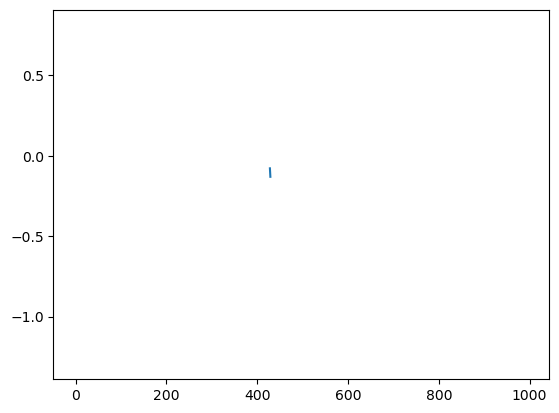

In [303]:
plt.plot(f.veri_data[5,:].where(f.varno==39).values[:1000] - g.veri_data[5,:].where(g.varno==39).values[:1000])
plt.plot(y.veri_data[5,:].where(y.varno==39).values[:1000] - x.veri_data[5,:].where(x.varno==39).values[:1000])

In [177]:
#those are for 2022

opr_12_bb = xr.open_dataset('../det_12_hour_data/fc_DOM01_0001_OPR_grid_bb.nc')
opr_24_bb = xr.open_dataset('../det_12_hour_data/fc_DOM01_0002_OPR_grid_bb.nc')
opr_12_cities = xr.open_dataset('../det_12_hour_data/fc_DOM01_0001_OPR_urban_grid.nc')
opr_24_cities = xr.open_dataset('../det_12_hour_data/fc_DOM01_0002_OPR_urban_grid.nc')

urb_12_bb = xr.open_dataset('../det_12_hour_data/fc_DOM01_0001_URB_grid_bb.nc')
urb_24_bb = xr.open_dataset('../det_12_hour_data/fc_DOM01_0002_URB_grid_bb.nc')
urb_12_cities = xr.open_dataset('../det_12_hour_data/fc_DOM01_0001_URB_urban_grid.nc')
urb_24_cities = xr.open_dataset('../det_12_hour_data/fc_DOM01_0002_URB_urban_grid.nc')

In [ ]:
urb_12_cities

In [178]:
excluded_lat = opr_12_cities["clat"].isel(cell=74).values
excluded_lon = opr_12_cities["clon"].isel(cell=74).values

In [179]:
index_to_drop = (opr_12_bb['clat'] == excluded_lat) & (opr_12_bb['clon'] == excluded_lon)
opr_12_bb_ob = opr_12_bb.where(~index_to_drop, drop=True)
opr_24_bb_ob = opr_24_bb.where(~index_to_drop, drop=True)
urb_12_bb_ob = urb_12_bb.where(~index_to_drop, drop=True)
urb_24_bb_ob = urb_24_bb.where(~index_to_drop, drop=True)

In [180]:
class model_kdtree(object):
    def __init__(self):
        model_ds = opr_12_bb_ob
        self.model_ds = model_ds
        self.kdtree = {}
        self.kdtree = KDTree(np.asarray([self.model_ds.clat.values.flatten(),
                                         self.model_ds.clon.values.flatten()]).T)
    
    def query(self, lat_az0, lon_az0, k=10):
        distances, indices1d = self.kdtree.query(np.asarray([lat_az0, lon_az0]).T, k=k)
        return indices1d


In [181]:
tree_icon = model_kdtree()
tree_icon.kdtree

In [182]:
indices_cities_ens = tree_icon.query(np.asarray(opr_12_cities["clon"].isel(cell=74).clat.values),
                                     np.asarray(opr_12_cities["clon"].isel(cell=74).clon.values),
                                     k=10)

In [183]:
opr_12_bb_10_nearest = opr_12_bb_ob.isel(cell=indices_cities_ens)
opr_24_bb_10_nearest = opr_24_bb_ob.isel(cell=indices_cities_ens)

urb_12_bb_10_nearest = urb_12_bb_ob.isel(cell=indices_cities_ens)
urb_24_bb_10_nearest = urb_24_bb_ob.isel(cell=indices_cities_ens)

In [208]:
print('Difference OPR [10 rural grid points around Berlin - Berlin], LH [W m-2] 00:00 UTC =' , np.mean(opr_12_bb_10_nearest.LHFL_S.values) - opr_12_cities.LHFL_S.isel(cell=74).values)
print('Difference URB [10 rural grid points around Berlin - Berlin], LH [W m-2] 00:00 UTC =' , np.mean(urb_12_bb_10_nearest.LHFL_S.values) - urb_12_cities.LHFL_S.isel(cell=74).values)


Difference OPR [10 rural grid points around Berlin - Berlin], LH [W m-2] 00:00 UTC = [4.325]
Difference URB [10 rural grid points around Berlin - Berlin], LH [W m-2] 00:00 UTC = [0.490625]


In [199]:
print('Difference OPR [10 rural grid points around Berlin - Berlin], LH [W m-2] 12:00 UTC =' , np.mean(opr_24_bb_10_nearest.LHFL_S.values) - opr_24_cities.LHFL_S.isel(cell=74).values)
print('Difference URB [10 rural grid points around Berlin - Berlin], LH [W m-2] 12:00 UTC =' , np.mean(urb_24_bb_10_nearest.LHFL_S.values) - urb_24_cities.LHFL_S.isel(cell=74).values)


Difference OPR [10 rural grid points around Berlin - Berlin], LH [W m-2] 12:00 UTC = [-29.131256]
Difference URB [10 rural grid points around Berlin - Berlin], LH [W m-2] 12:00 UTC = [-94.78439]


In [225]:
opr_12_cities.SHFL_S.isel(cell=74).values

array([12.628845], dtype=float32)

In [207]:
print('Difference OPR [10 rural grid points around Berlin - Berlin], SH [W m-2] 00:00 UTC =' , np.mean(opr_12_bb_10_nearest.SHFL_S.values) - opr_12_cities.SHFL_S.isel(cell=74).values)
print('Difference URB [10 rural grid points around Berlin - Berlin], SH [W m-2] 00:00 UTC =' , np.mean(urb_12_bb_10_nearest.SHFL_S.values) - urb_12_cities.SHFL_S.isel(cell=74).values)


Difference OPR [10 rural grid points around Berlin - Berlin], SH [W m-2] 00:00 UTC = [2.7578125]
Difference URB [10 rural grid points around Berlin - Berlin], SH [W m-2] 00:00 UTC = [6.23125]


In [226]:
print('Difference OPR [10 rural grid points around Berlin - Berlin], SH [W m-2] 12:00 UTC =' , np.mean(opr_24_bb_10_nearest.SHFL_S.values) - opr_24_cities.SHFL_S.isel(cell=74).values)
print('Difference URB [10 rural grid points around Berlin - Berlin], SH [W m-2] 12:00 UTC=' , np.mean(urb_24_bb_10_nearest.SHFL_S.values) - urb_24_cities.SHFL_S.isel(cell=74).values)


Difference OPR [10 rural grid points around Berlin - Berlin], SH [W m-2] 12:00 UTC = [30.898438]
Difference URB [10 rural grid points around Berlin - Berlin], SH [W m-2] 12:00 UTC= [62.967224]


In [230]:
np.mean(opr_24_bb_10_nearest.SHFL_S.values) - (opr_24_cities.SHFL_S.isel(cell=74).values)

array([30.898438], dtype=float32)

In [205]:
np.mean(urb_24_bb_10_nearest.SHFL_S.values)

-271.34247

In [195]:
opr_24_cities.SHFL_S.isel(cell=74).values

array([-303.12408], dtype=float32)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/srv/conda3/envs/py39-cartopy/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/srv/conda3/envs/py39-cartopy/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


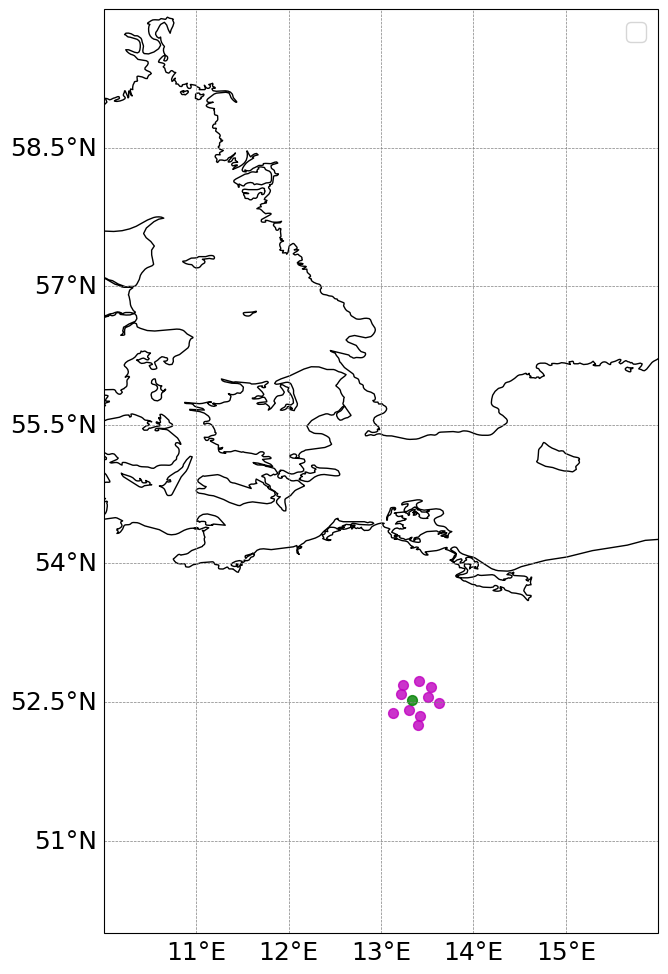

In [145]:
cx = np.degrees(np.asarray(urb_12_bb_ob["clon"]))
cy = np.degrees(np.asarray(urb_12_bb_ob["clat"]))

cx_opr = np.degrees(np.asarray(opr_12_bb_ob["clon"]))
cy_opr = np.degrees(np.asarray(opr_12_bb_ob["clat"]))

cx_berlin = np.degrees(np.asarray(opr_12_cities["clon"].isel(cell=74)))
cy_berlin = np.degrees(np.asarray(opr_12_cities["clat"].isel(cell=74)))

cx_nearest = np.degrees(np.asarray(opr_12_bb_10_nearest["clon"]))
cy_nearest = np.degrees(np.asarray(opr_12_bb_10_nearest["clat"]))

fig = plt.figure(figsize=(12,12))
ax = plt.axes(projection=ccrs.PlateCarree())
#ax.scatter(cx, cy, s=50, c='blue', alpha=0.8, transform=ccrs.PlateCarree())
ax.scatter(cx_nearest, cy_nearest, s=50, c='m', alpha=0.8, transform=ccrs.PlateCarree())
ax.scatter(cx_berlin, cy_berlin, s=50, c='green', alpha=0.8, transform=ccrs.PlateCarree())
#ax.scatter(cx_opr, cy_opr, s=50, c='yellow', alpha=0.8, transform=ccrs.PlateCarree())

ax.coastlines()
ax.set_extent([10, 16, 50, 60], crs=ccrs.PlateCarree())
ax.legend(fontsize=18)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linestyle='--', linewidth=0.5, color='gray')
gl.xlabels_top = gl.ylabels_right = False
gl.xlabel_style, gl.ylabel_style = {'fontsize': 18}, {'fontsize': 18}